### Importing Libraries

In [408]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [409]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA 
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

#### Reading the data into a dataframe

In [410]:
df = pd.read_csv("C:/Users/HP/Documents/HamoyeDSI/household_power_consumption.txt", delimiter=";", dtype="unicode")
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


### Data Wrangling

#### Assigning the correct data type for each column

In [411]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB


In [412]:
# Converting the Date and Time columns to datetime
df["datetime"] = pd.to_datetime(df["Date"] + ' ' + df["Time"], dayfirst=True)

# Function to convert all the other columns to floats
def obj_to_float(dataframe, column):
    dataframe[column] = pd.to_numeric(dataframe[column], errors= "coerce")
    return dataframe
    
# Applying the obj_to_float column
objects = ["Global_active_power", "Global_reactive_power","Voltage", "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
for i in objects:
    obj_to_float(df, i)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   object        
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 158.3+ MB


#### Handling missing values

In [413]:
# Checking for missing values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
datetime                     0
dtype: int64

In [414]:
#Filling missing values with forward fill
numeric_df = df.select_dtypes(include=[np.number])
numeric_df = numeric_df.fillna(method= 'ffill')  
numeric_df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [415]:
numeric_df.insert(0, "datetime", df["datetime"])
numeric_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [416]:
resample_df = numeric_df.resample("H", on= "datetime").sum()
resample_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


In [417]:
df2 = resample_df.copy()

In [418]:
df2.reset_index(inplace= True)
df2.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
1,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
3,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
4,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


### Exploratory Data Analysis (EDA)

In [419]:
df2.corr()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,1.000000,-0.052986,0.071931,0.245971,-0.058154,-0.027109,-0.054133,0.057705
Global_active_power,-0.052986,1.000000,0.309464,-0.340758,0.999414,0.497064,0.440504,0.696577
Global_reactive_power,0.071931,0.309464,1.000000,-0.129650,0.325762,0.326167,0.255600,0.105055
Voltage,0.245971,-0.340758,-0.129650,1.000000,-0.353145,-0.186282,-0.145793,-0.242989
Global_intensity,-0.058154,0.999414,0.325762,-0.353145,1.000000,0.505443,0.447781,0.686647
Sub_metering_1,-0.027109,0.497064,0.326167,-0.186282,0.505443,1.000000,0.116436,0.197376
Sub_metering_2,-0.054133,0.440504,0.255600,-0.145793,0.447781,0.116436,1.000000,0.126188
Sub_metering_3,0.057705,0.696577,0.105055,-0.242989,0.686647,0.197376,0.126188,1.000000


In [420]:
df2.shape

(34589, 8)

Text(0, 0.5, 'Global Reactive Power')

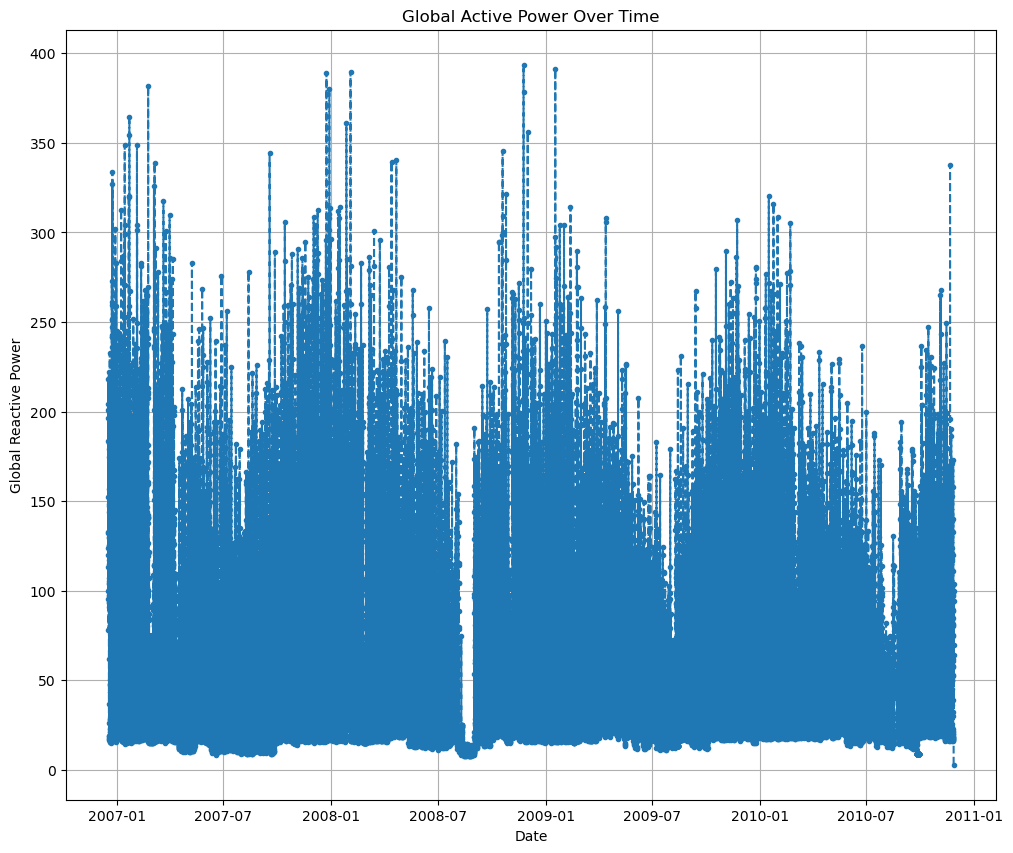

In [421]:
# Plot of Global_active_power over time
plt.figure(figsize=(12,10))
plt.plot(df2.datetime, df2.Global_active_power, '--', marker= ".")
plt.grid()
plt.title("Global Active Power Over Time")
plt.xlabel('Date')
plt.ylabel('Global Reactive Power')

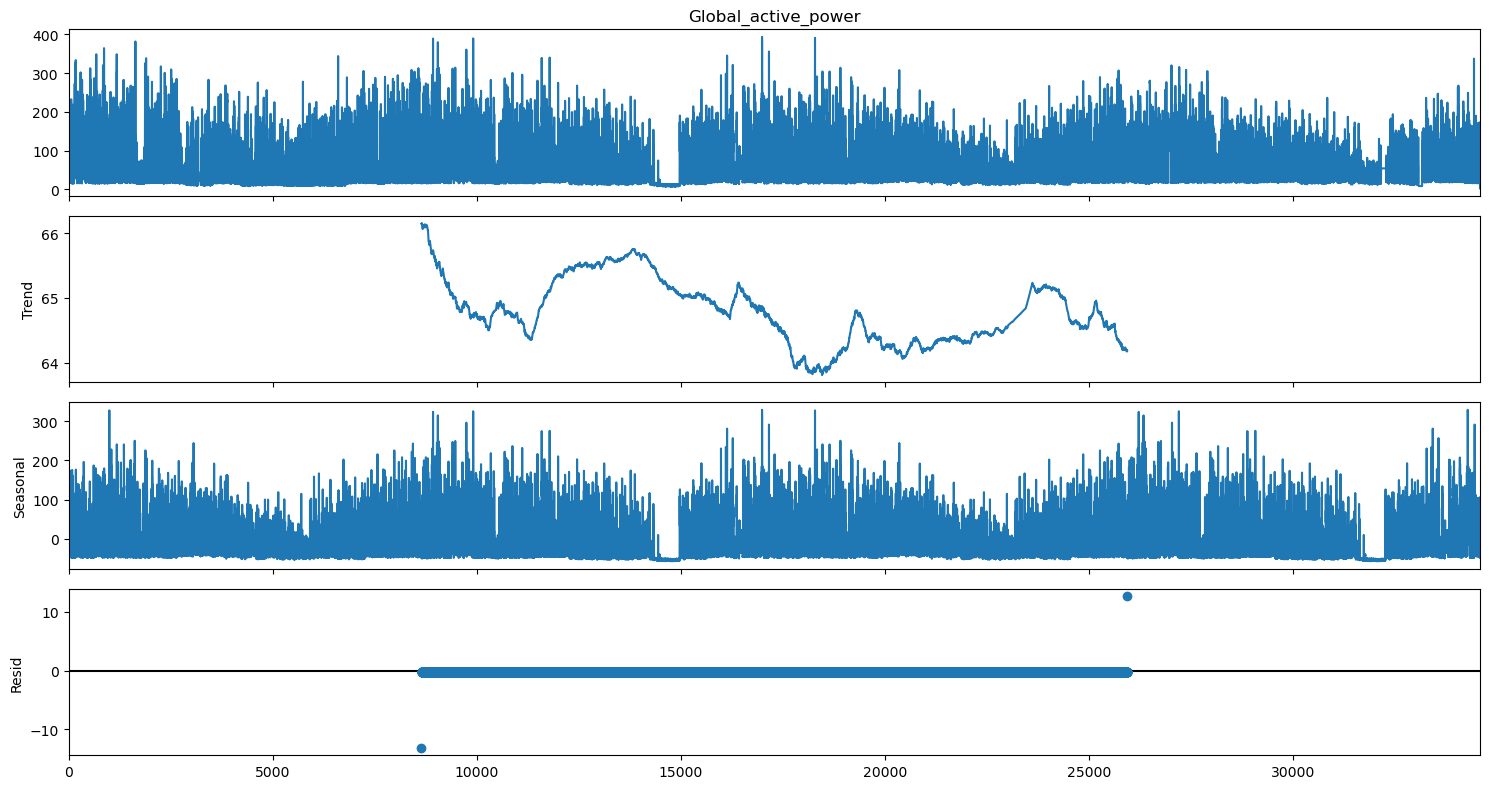

In [422]:
rcParams["figure.figsize"] = 15,8  
decompose_series = sm.tsa.seasonal_decompose(df2["Global_active_power"], model= "additive", period = int(len(resample_df)/2))  
decompose_series.plot()  
plt.show() 

### Univariate Time Series Forecasting

In [423]:
# Renaming the datetime column to "dt" and the Global_reactive_power column to "y"
df3 = df2.copy()
df3.rename(columns = {"datetime":"ds", "Global_active_power":"y"}, inplace= True)
df3.head()

,ds,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
1,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
3,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
4,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


In [424]:
df4 = df3[["ds", "y"]]
df4.head()

,ds,y
0,2006-12-16 17:00:00,152.024
1,2006-12-16 18:00:00,217.932
2,2006-12-16 19:00:00,204.014
3,2006-12-16 20:00:00,196.114
4,2006-12-16 21:00:00,183.388


In [425]:
len(df4)

34589

In [426]:
train = df4.iloc[:1142,:]
test = df4.iloc[1142:,:]
print(f"length of training set: {len(train)}, length of test set: {len(test)}")

length of training set: 1142, length of test set: 33447


In [427]:
train.head()

,ds,y
0,2006-12-16 17:00:00,152.024
1,2006-12-16 18:00:00,217.932
2,2006-12-16 19:00:00,204.014
3,2006-12-16 20:00:00,196.114
4,2006-12-16 21:00:00,183.388


In [428]:
# Defining the univariate prediction model
fbp = Prophet()

In [429]:
# Fitting the univariate prediction model
fbp.fit(train)

18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing


In [430]:
pred_test = fbp.predict(test)

In [431]:
pred_test.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-02-02 07:00:00,88.623777,10.140547,155.588741,88.623777,88.623777,-10.150650,-10.150650,-10.150650,6.643553,6.643553,6.643553,-16.794203,-16.794203,-16.794203,0.0,0.0,0.0,78.473127
1,2007-02-02 08:00:00,88.607066,22.805516,168.722346,88.607066,88.607066,7.290748,7.290748,7.290748,24.044234,24.044234,24.044234,-16.753486,-16.753486,-16.753486,0.0,0.0,0.0,95.897814
2,2007-02-02 09:00:00,88.590356,24.886719,175.263761,88.590356,88.590356,7.475246,7.475246,7.475246,24.085816,24.085816,24.085816,-16.610570,-16.610570,-16.610570,0.0,0.0,0.0,96.065602
3,2007-02-02 10:00:00,88.573646,11.895748,157.465839,88.573646,88.573646,-4.268423,-4.268423,-4.268423,12.091709,12.091709,12.091709,-16.360132,-16.360132,-16.360132,0.0,0.0,0.0,84.305223
4,2007-02-02 11:00:00,88.556936,-8.279182,143.585948,88.556936,88.556936,-16.666939,-16.666939,-16.666939,-0.669284,-0.669284,-0.669284,-15.997656,-15.997656,-15.997656,0.0,0.0,0.0,71.889996


In [433]:
pred = pred_test[['ds', 'yhat']]
pred.head()

,ds,yhat
0,2007-02-02 07:00:00,78.473127
1,2007-02-02 08:00:00,95.897814
2,2007-02-02 09:00:00,96.065602
3,2007-02-02 10:00:00,84.305223
4,2007-02-02 11:00:00,71.889996


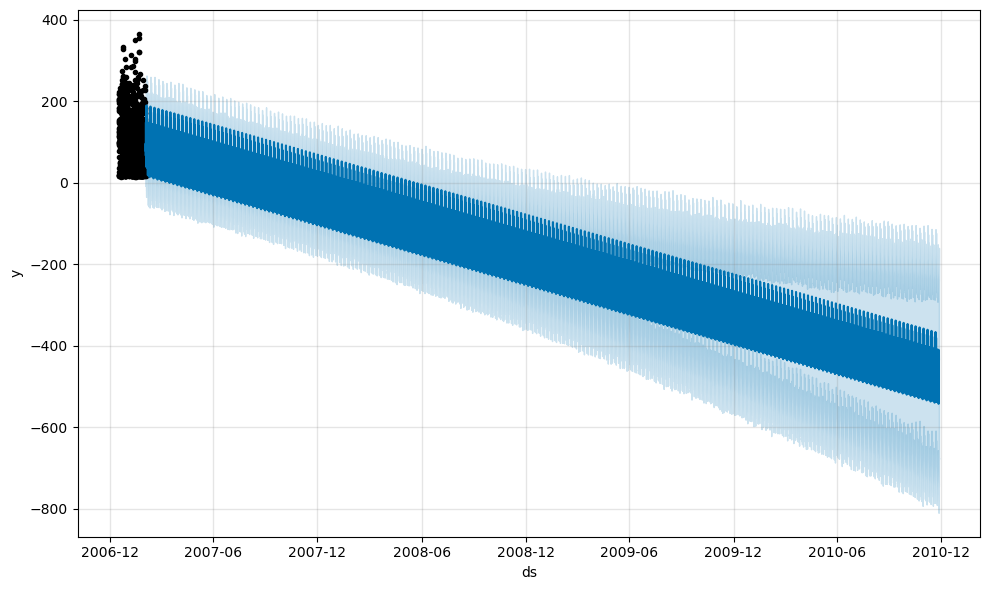

In [452]:
# Plot of the predicted variables over time
fbp.plot(pred_test)
plt.show()

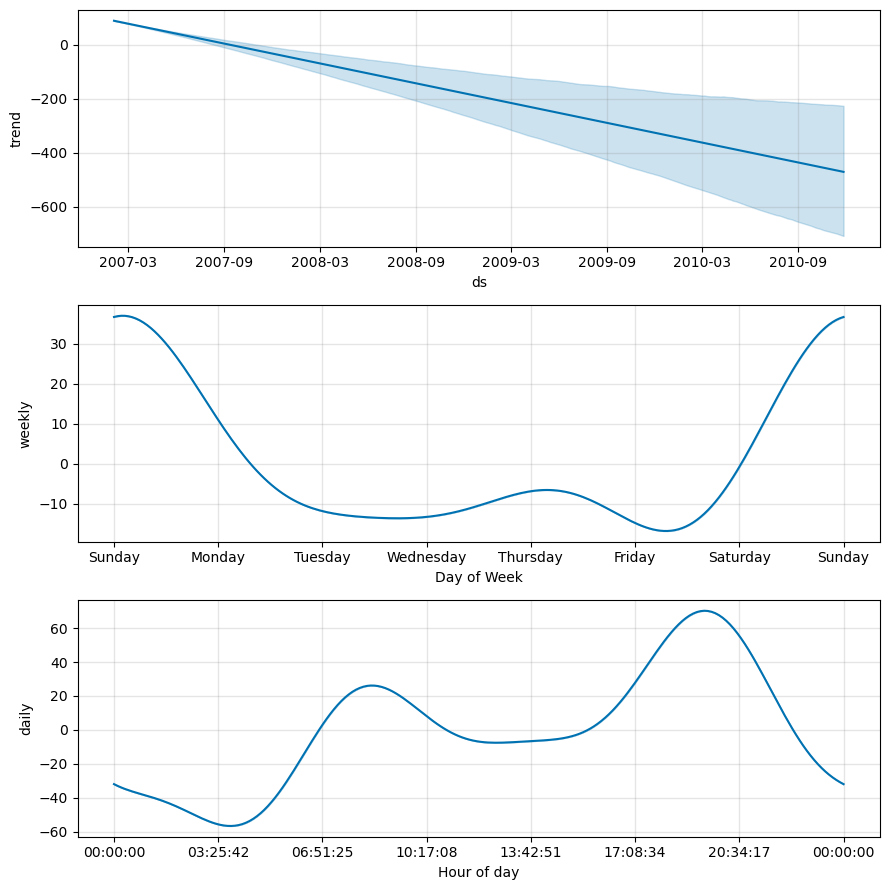

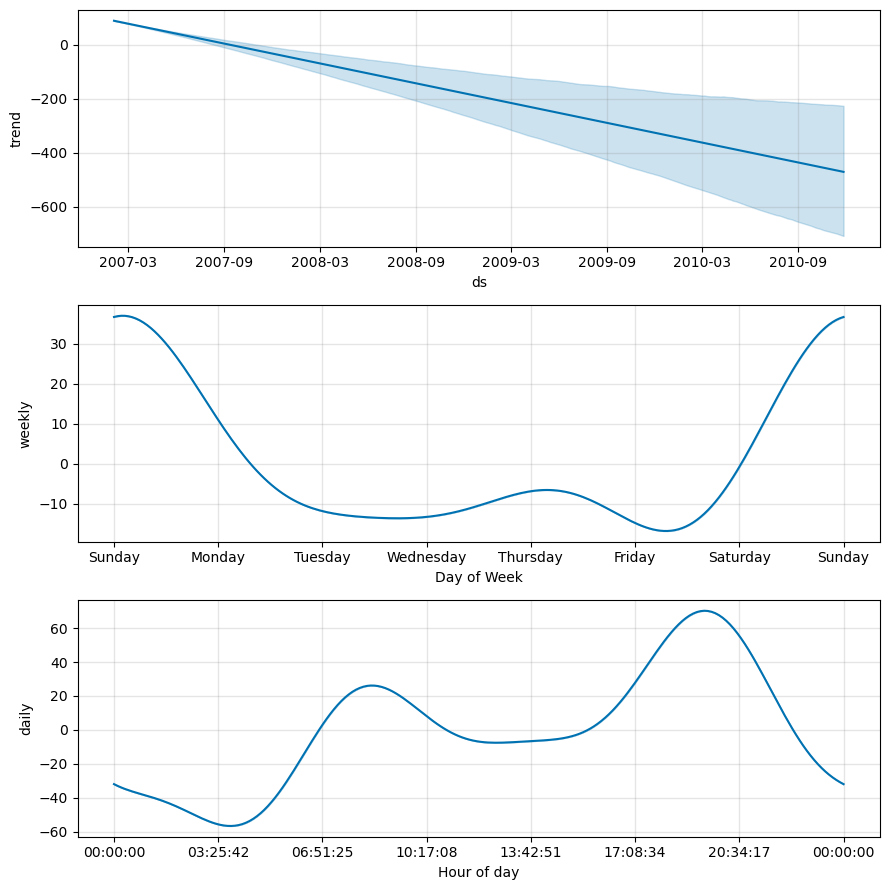

In [434]:
fbp.plot_components(pred_test)

In [435]:
# Calculating the mean absolute percentage error
def mape(true_value, predicted_value):
    diff = 0
    for i,j in zip(true_value, predicted_value):
        diff+= np.abs((i-j)/i)* 100
    return diff/len(true_value)

In [436]:
mean_ape = mape(test["y"], pred["yhat"])
print(mean_ape)

701.8733574169792


In [437]:
# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(test.y, pred.yhat))
print(rmse)

305.2449607293352


In [438]:
# Mean Absolute Error
mae = mean_absolute_error(test.y, pred.yhat)
print(mae)

259.35279244769964


#### Multivariate Time Series Forecasting

In [439]:
# Renaming the regressors
df3.rename(columns= {"Global_reactive_power":"add1", "Voltage":"add2", "Global_intensity":"add3", 
                     "Sub_metering_1":"add4", "Sub_metering_2":"add5", "Sub_metering_3":"add6"}, inplace= True)
df3.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
1,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
3,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
4,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


In [440]:
# Splitting the data
multi_train = df3.iloc[:1142,:]
multi_test = df3.iloc[1142:,:]
print(f"length of training set: {len(multi_train)}, length of test set: {len(multi_test)}")

length of training set: 1142, length of test set: 33447


In [441]:
# Defining the multivariate prediction model
multi_fbp = Prophet()
multi_fbp.add_regressor("add1")
multi_fbp.add_regressor("add2")
multi_fbp.add_regressor("add3")
multi_fbp.add_regressor("add4")
multi_fbp.add_regressor("add5")
multi_fbp.add_regressor("add6")

In [442]:
# Fitting the multivaraite prediction model
multi_fbp.fit(multi_train)

18:55:13 - cmdstanpy - INFO - Chain [1] start processing
18:55:14 - cmdstanpy - INFO - Chain [1] done processing


In [443]:
# Making predictions on the test set
multi_pred = multi_fbp.predict(multi_test)

In [444]:
multi_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-02-02 07:00:00,98.853330,135.353133,139.487350,98.853330,98.853330,0.536559,0.536559,0.536559,-0.208596,...,37.893973,37.893973,37.893973,0.562080,0.562080,0.562080,0.0,0.0,0.0,137.228924
1,2007-02-02 08:00:00,98.853083,89.035037,92.973597,98.853083,98.853083,0.067380,0.067380,0.067380,-0.120424,...,-8.660948,-8.660948,-8.660948,0.569745,0.569745,0.569745,0.0,0.0,0.0,90.901667
2,2007-02-02 09:00:00,98.852835,88.817306,92.934970,98.852835,98.852835,0.534375,0.534375,0.534375,-0.245978,...,-8.729108,-8.729108,-8.729108,0.574718,0.574718,0.574718,0.0,0.0,0.0,90.971457
3,2007-02-02 10:00:00,98.852588,99.478440,103.731685,98.852588,98.852588,0.328618,0.328618,0.328618,-0.343239,...,2.032209,2.032209,2.032209,0.576584,0.576584,0.576584,0.0,0.0,0.0,101.623121
4,2007-02-02 11:00:00,98.852340,76.072609,80.224271,98.852340,98.852340,0.181835,0.181835,0.181835,-0.235894,...,-21.136139,-21.136139,-21.136139,0.574944,0.574944,0.574944,0.0,0.0,0.0,78.197213


In [445]:
pred2 = multi_pred[['ds', 'yhat']]
pred2.head()

,ds,yhat
0,2007-02-02 07:00:00,137.228924
1,2007-02-02 08:00:00,90.901667
2,2007-02-02 09:00:00,90.971457
3,2007-02-02 10:00:00,101.623121
4,2007-02-02 11:00:00,78.197213


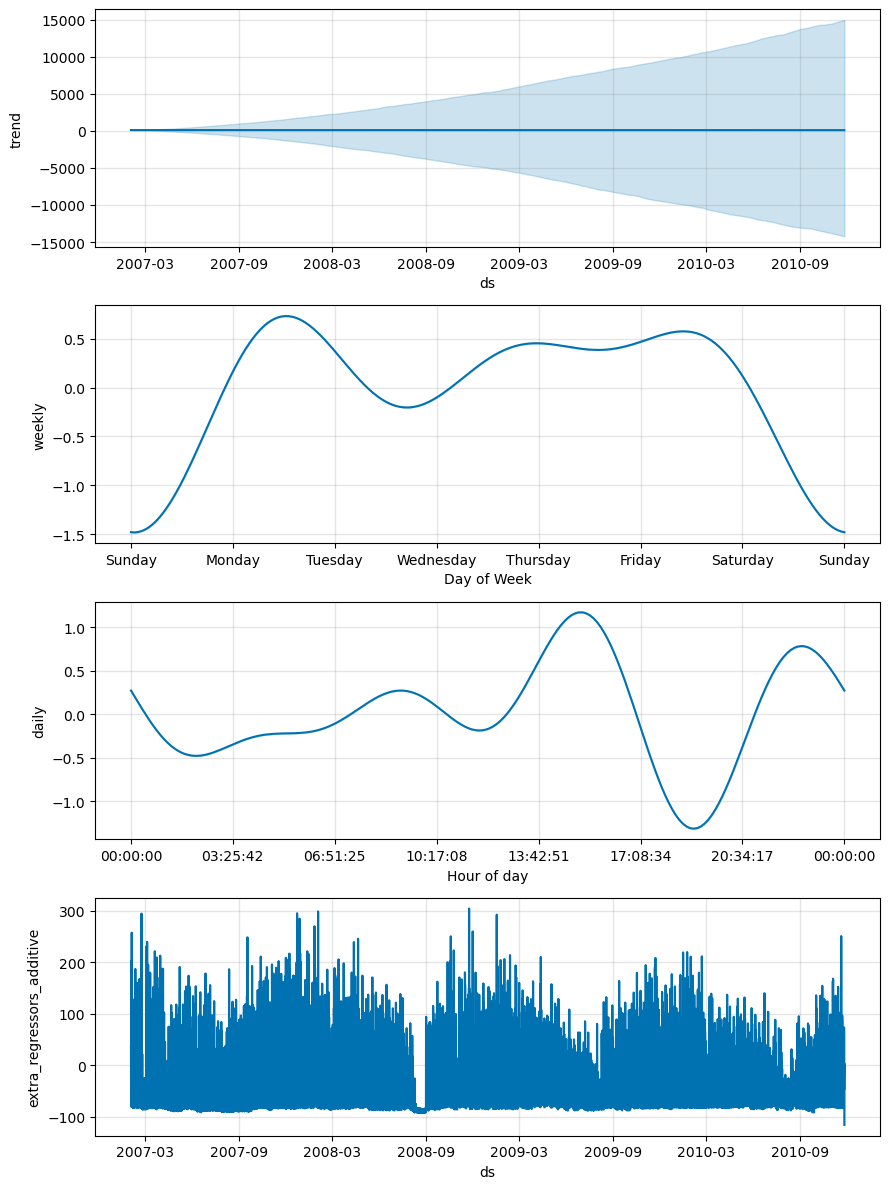

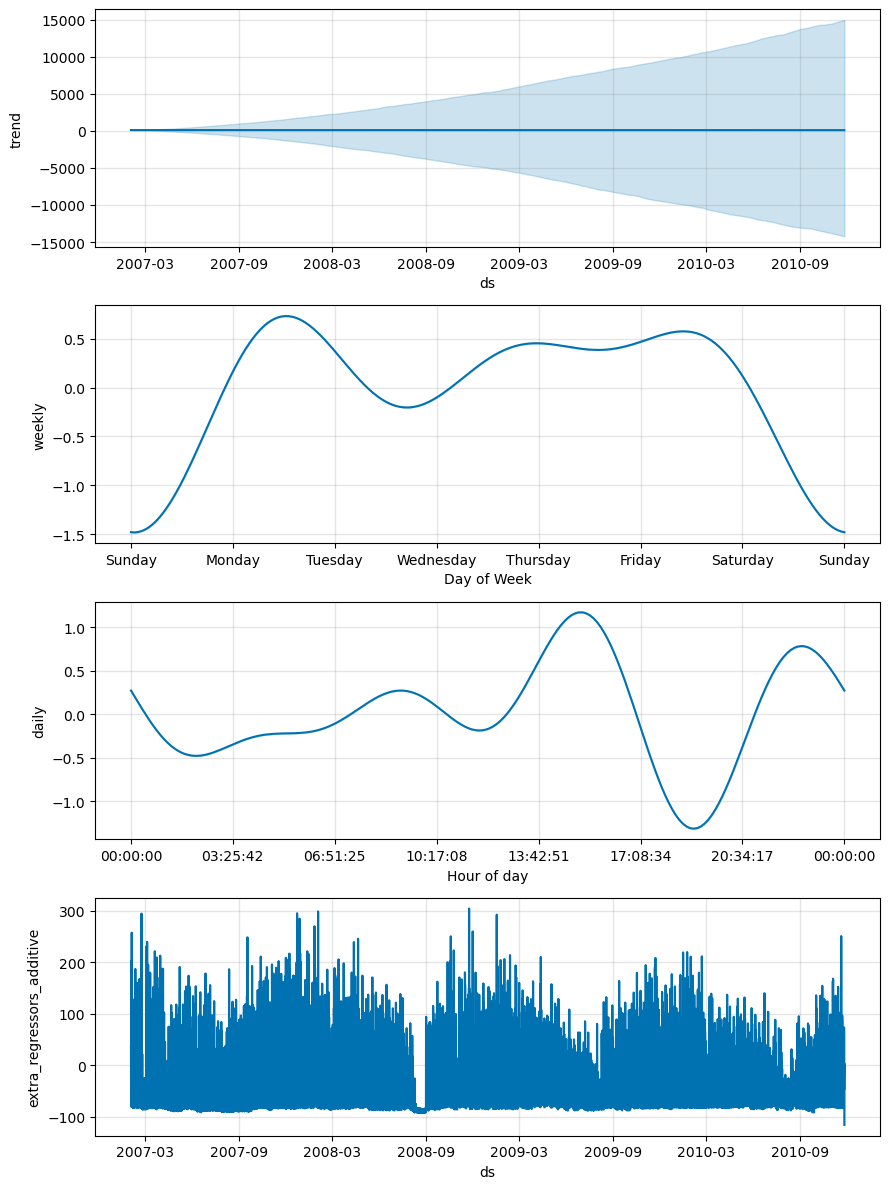

In [446]:
multi_fbp.plot_components(multi_pred)

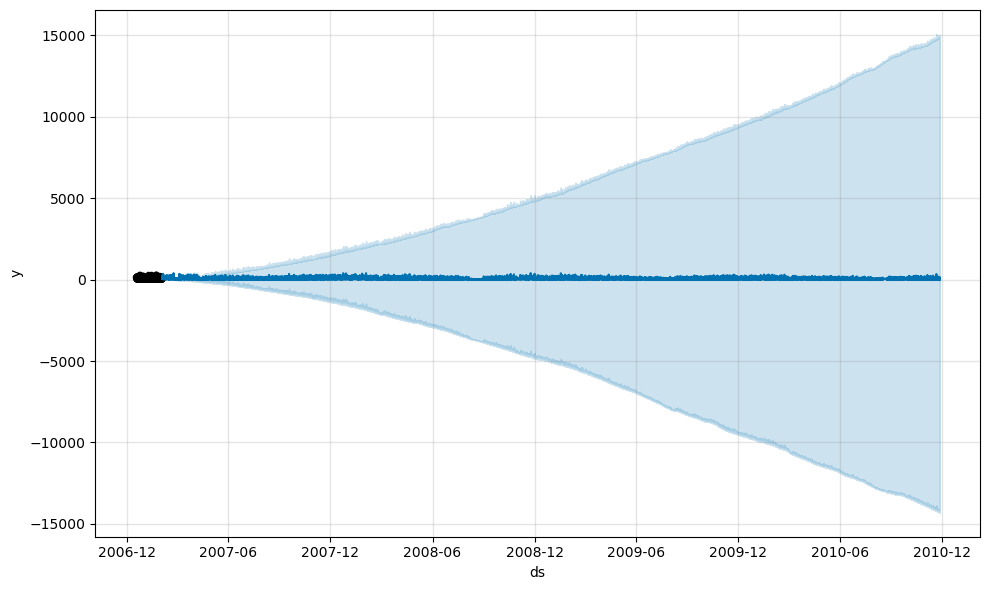

In [447]:
# Plot of the predicted variables over time
multi_fbp.plot(multi_pred)
plt.show()

In [448]:
# Mean Absolute Percentage Error
multi_mean_ape = mape(multi_test["y"], pred2["yhat"])
print(multi_mean_ape)

12.857826379844681


In [449]:
# Root Mean Square Error
multi_rmse = np.sqrt(mean_squared_error(multi_test.y, pred2.yhat))
print(multi_rmse)

5.304571625068637


In [450]:
# Mean Absolute Error
multi_mae = mean_absolute_error(multi_test.y, pred2.yhat)
print(multi_mae)

4.538753920879749


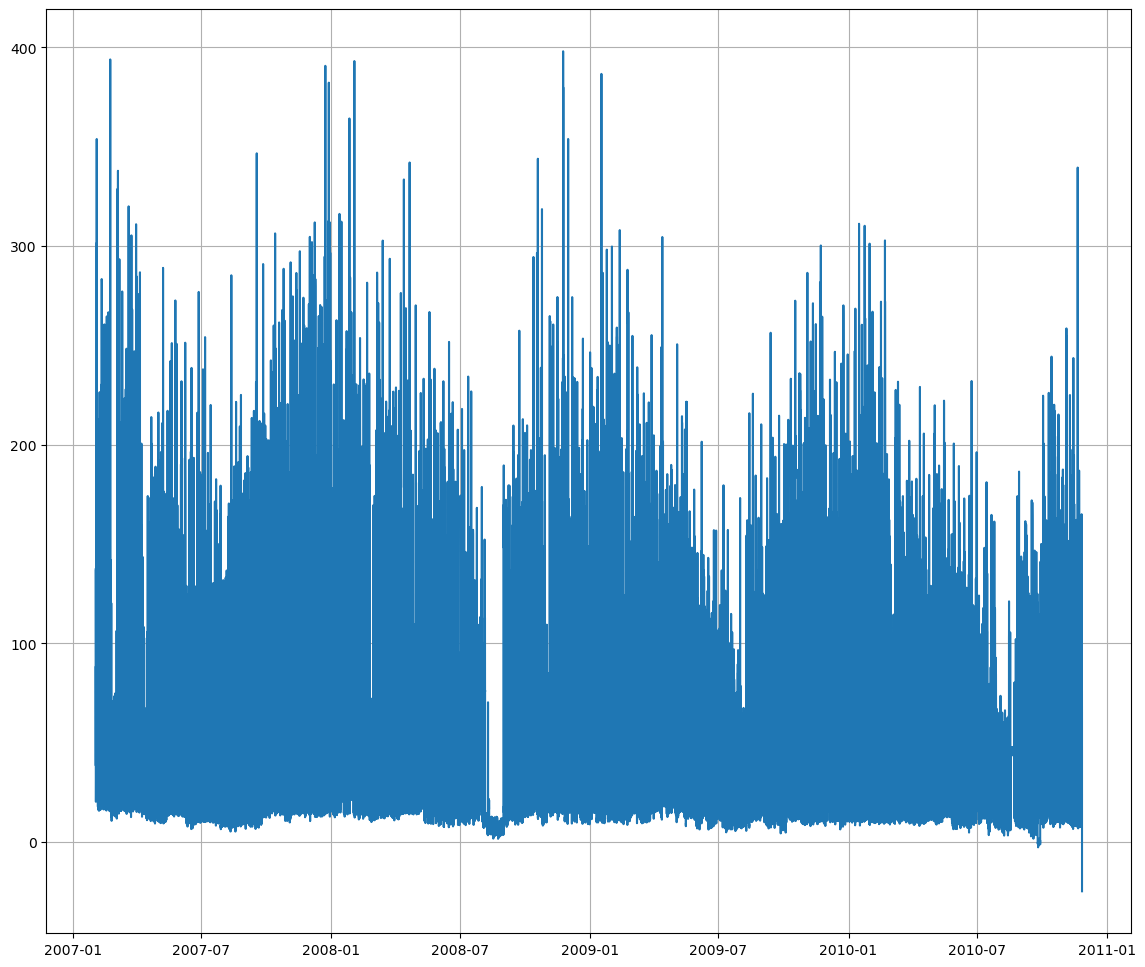

In [451]:
# Plot of the predicted values for Global Active Power with multiple regressors over time
plt.figure(figsize= (14,12))
plt.plot(pred2.ds, pred2.yhat)
plt.grid()